In [14]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random

In [15]:
# classes.csv look up
df_clases = pd.read_csv(r"C:\Users\Michal Miszczobrocki\.kaggle\wikiart\classes.csv")
df_clases.head()

,filename,artist,genre,description,phash,width,height,genre_count,subset
0,Abstract_Expressionism/aaron-siskind_acolman-1...,aaron siskind,['Abstract Expressionism'],acolman-1-1955,bebbeb018a7d80a8,1922,1382,1,train
1,Abstract_Expressionism/aaron-siskind_chicago-6...,aaron siskind,['Abstract Expressionism'],chicago-6-1961,d7d0781be51fc00e,1382,1746,1,train
2,Abstract_Expressionism/aaron-siskind_glouceste...,aaron siskind,['Abstract Expressionism'],gloucester-16a-1944,9f846e5a6c639325,1382,1857,1,train
3,Abstract_Expressionism/aaron-siskind_jerome-ar...,aaron siskind,['Abstract Expressionism'],jerome-arizona-1949,a5d691f85ac5e4d0,1382,1849,1,train
4,Abstract_Expressionism/aaron-siskind_kentucky-...,aaron siskind,['Abstract Expressionism'],kentucky-4-1951,880df359e6b11db1,1382,1625,1,train


In [16]:
df_clases["filename"][0]

'Abstract_Expressionism/aaron-siskind_acolman-1-1955.jpg'

In [17]:
# wclasses.csv look up
df_wclasses = pd.read_csv(r"C:\Users\Michal Miszczobrocki\.kaggle\wikiart\wclasses.csv")
df_wclasses.head()

,file,artist,genre,style
0,Realism/vincent-van-gogh_pine-trees-in-the-fen...,22,133,161
1,Baroque/rembrandt_the-angel-appearing-to-the-s...,20,136,144
2,Post_Impressionism/paul-cezanne_portrait-of-th...,16,135,160
3,Impressionism/pierre-auguste-renoir_young-girl...,17,131,152
4,Romanticism/ivan-aivazovsky_morning-1851.jpg,9,139,163


In [18]:
df_wclasses["file"][0]

'Realism/vincent-van-gogh_pine-trees-in-the-fen-1884.jpg'

In [19]:
class WikiArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx,1]

        if self.transform:
            image = self.transform(image)

        return image

In [20]:
root_dir = r"C:\Users\Michal Miszczobrocki\.kaggle\wikiart"
csv_file = r"C:\Users\Michal Miszczobrocki\.kaggle\wikiart\wclasses.csv"

dataset = WikiArtDataset(csv_file, root_dir)

In [21]:
def show_image_from_dataset(dataset, idx):
    img = dataset[idx]

    # If an image is a tensor -> convert to numpy
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0) 

        plt.imshow(img.numpy())
        plt.axis('off')  
        plt.show()
    
    # If an image is of type PIL.Image.Image
    elif isinstance(img, Image.Image):
        plt.imshow(img)
        plt.axis('off')  
        plt.show()

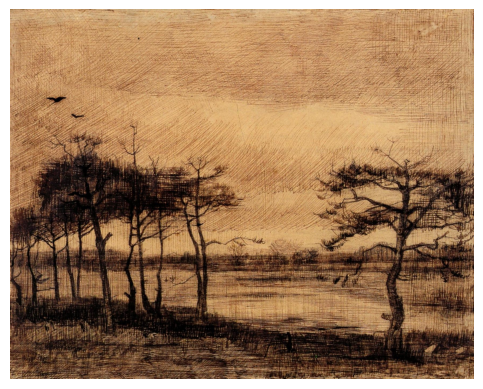

In [22]:
show_image_from_dataset(dataset,idx=0)

In [23]:
import random
from PIL import Image

class RandomMask:
    def __init__(self, max_size_fraction=1/16, max_vertices=8, mask_choice=None):
        self.mask_max_size = max_size_fraction
        self.max_vertices = max_vertices
        self.mask_choice = mask_choice

    def __call__(self, image):
        # Randomly decide between square mask and random mask
        if self.mask_choice is None:
            self.mask_choice = random.choice(["square", "random_square", "random_polygon"])
            # print(f"{mask_choice = }")
        
        # Mask size, dimensions 
        im_width, im_height = image.size
        max_mask_size = int((im_width * im_height) * self.mask_max_size)
        square_mask_size = int(max_mask_size ** 0.5)

        if self.mask_choice == "square":
            # Random mask coordinates
            x = random.randint(0, im_width - square_mask_size)
            y = random.randint(0, im_height - square_mask_size)

            # Create and apply the square mask
            region = image.crop((x, y, x + square_mask_size, y + square_mask_size))
            image.paste((255, 255, 255), (x, y, x + square_mask_size, y + square_mask_size))
        
        elif self.mask_choice == "random_square":
            small_mask_size = 100
            iterations = max_mask_size // (small_mask_size * small_mask_size) 

            for _ in range(iterations):
                x = random.randint(0, im_width - small_mask_size)
                y = random.randint(0, im_height - small_mask_size)

                # Apply the random mask directly to the image
                image.paste((255, 255, 255), (x, y, x + small_mask_size, y + small_mask_size))
        
        elif self.mask_choice == "random_polygon":
            draw = ImageDraw.Draw(image)

            # Number of vertices
            num_vertices = random.randint(3, self.max_vertices)  
            vertices = []

            for _ in range(num_vertices):
                x = random.randint(0, im_width - 10)  
                y = random.randint(0, im_height - 10) 
                vertices.append((x, y))

            # Draw the polygon 
            if len(vertices) > 2:
                draw.polygon(vertices, fill=(255, 255, 255))

        return image


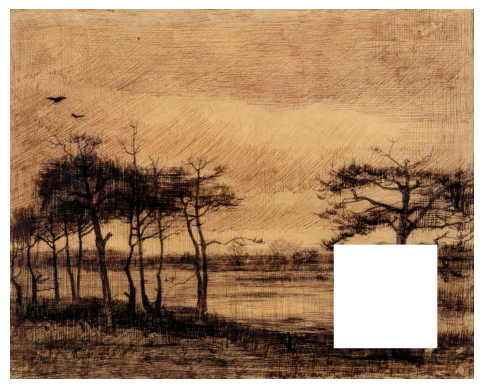

In [24]:
# Square
transform = transforms.Compose([
    RandomMask(mask_choice="square"), 
    transforms.ToTensor(),  
])

dataset_transformed = WikiArtDataset(csv_file, root_dir, transform=transform)
show_image_from_dataset(dataset_transformed, 0)

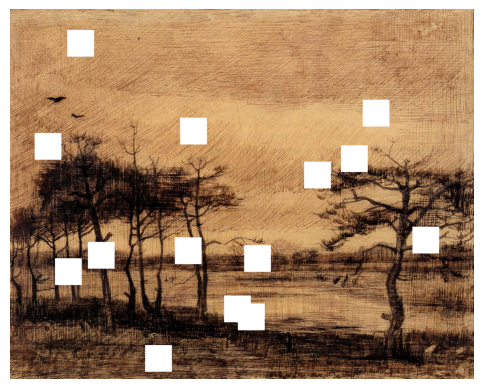

In [25]:
# Random square
transform = transforms.Compose([
    RandomMask(mask_choice="random_square"), 
    transforms.ToTensor(),  
])

dataset_transformed = WikiArtDataset(csv_file, root_dir, transform=transform)
show_image_from_dataset(dataset_transformed, 0)

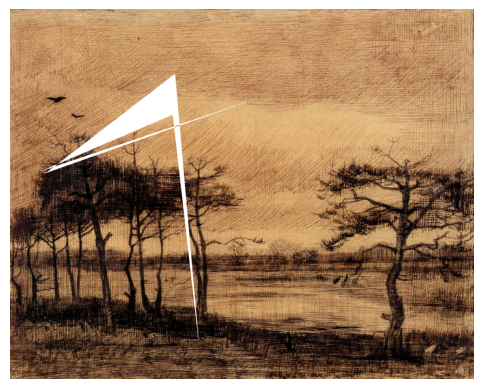

In [26]:
# Random polygon
transform = transforms.Compose([
    RandomMask(mask_choice="random_polygon"), 
    transforms.ToTensor(),  
])

dataset_transformed = WikiArtDataset(csv_file, root_dir, transform=transform)
show_image_from_dataset(dataset_transformed, 0)